In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchsummary import summary
import glob
import os
import pandas as pd
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
collab = False
BATCH_SIZE = 16
NUM_WORKERS = 4
EPOCHS = 1000


if collab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    ROOT_DIR = '/content/drive/MyDrive/ai_data/rov/data/cube'
    EPOCHS = 10000
    BATCH_SIZE = 32
else:
    ROOT_DIR = './data'

torch.Size([32, 3, 256, 256])


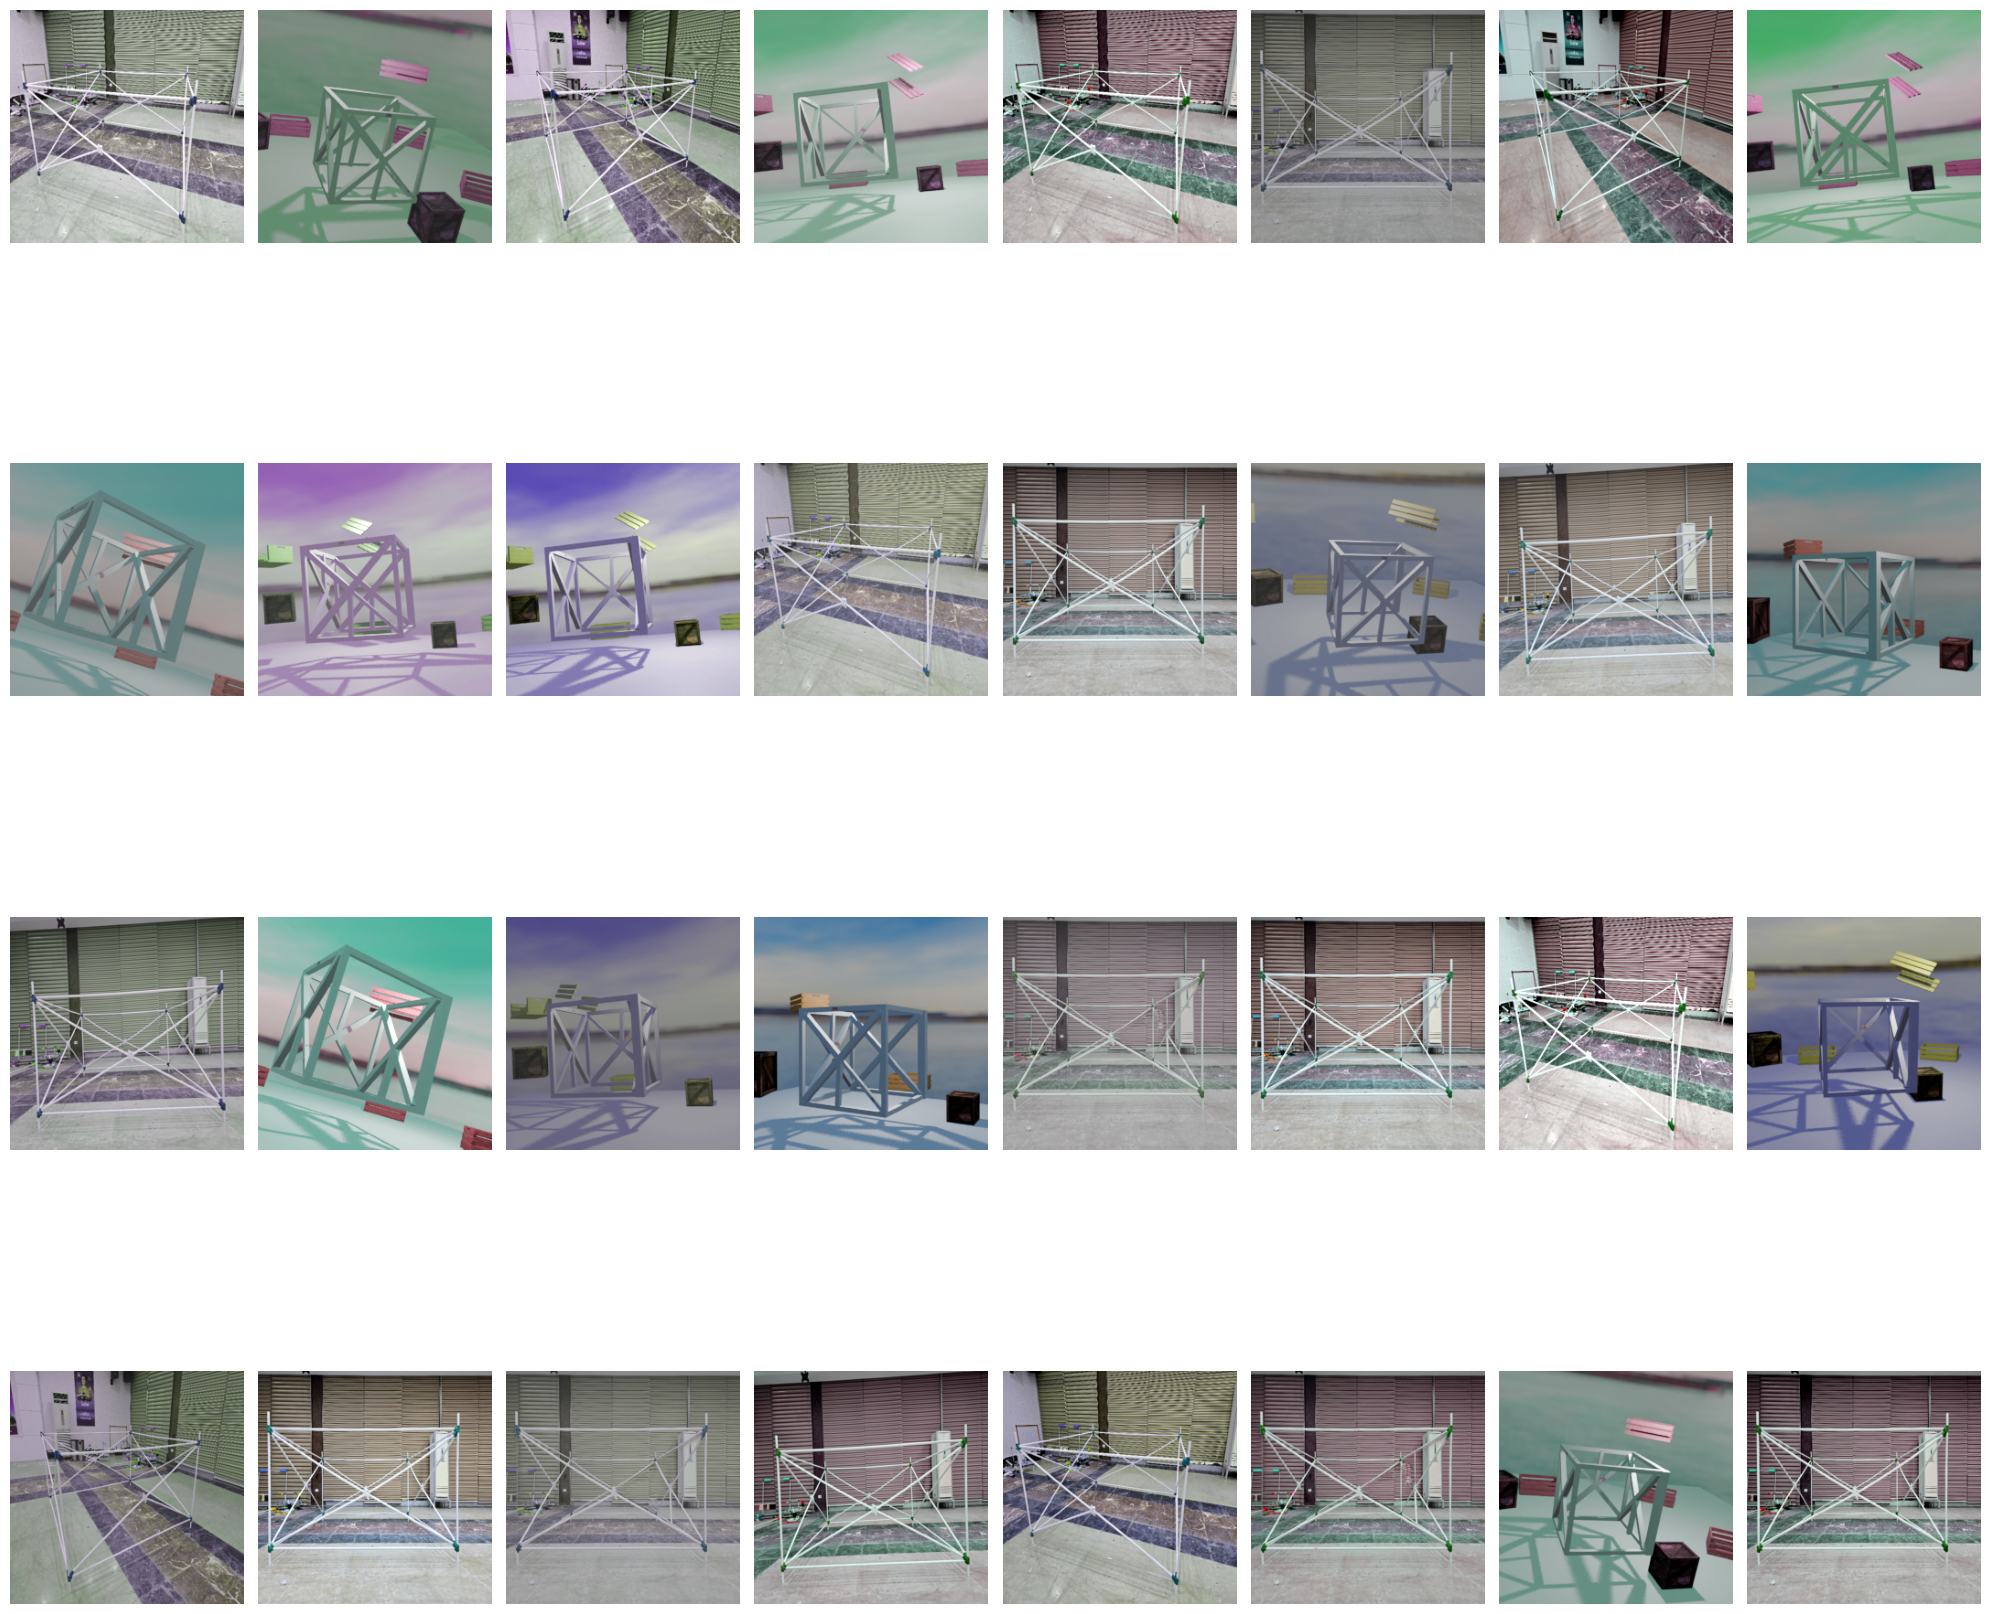

In [ ]:
class CubeDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform

        models_dir = os.path.join(ROOT_DIR, "models")
        real_dir = os.path.join(ROOT_DIR, "real")
        annots_dir = os.path.join(ROOT_DIR, "annots")

        # Load all annotation dataframes
        models_missing_df = pd.read_csv(os.path.join(annots_dir, "models_missing.csv"), dtype=str).set_index("dir_name")
        models_oxide_df = pd.read_csv(os.path.join(annots_dir, "models_oxide.csv"), dtype=str).set_index("dir_name")
        models_odd_df = pd.read_csv(os.path.join(annots_dir, "models_odd_size.csv"), dtype=str).set_index("dir_name")

        real_missing_df = pd.read_csv(os.path.join(annots_dir, "real_missing.csv"), dtype=str).set_index("name")
        real_oxide_df = pd.read_csv(os.path.join(annots_dir, "real_oxide.csv"), dtype=str).set_index("name")
        real_odd_df = pd.read_csv(os.path.join(annots_dir, "real_odd_size.csv"), dtype=str).set_index("name")

        self.data = []
        self.missing_labels = []
        self.oxide_labels = []
        self.odd_size_labels = []
        self.source = []  # 0 for artificial, 1 for real

        # Process artificial (models) data
        for model_path in glob.glob(os.path.join(models_dir, "*")):
            dir_name = os.path.basename(model_path)
            if (dir_name not in models_missing_df.index or
                dir_name not in models_oxide_df.index or
                dir_name not in models_odd_df.index):
                continue

            imgs = []
            for ext in ("*.jpeg", "*.jpg", "*.png"):
                imgs.extend(glob.glob(os.path.join(model_path, ext)))
            if not imgs:
                continue

            missing_ann = models_missing_df.loc[dir_name]
            oxide_ann = models_oxide_df.loc[dir_name]
            odd_ann = models_odd_df.loc[dir_name]

            missing_face_labels = [[int(c) for c in missing_ann[face].strip()] for face in ["front", "left", "back", "right"]]
            oxide_face_labels = [[int(c) for c in oxide_ann[face].strip()] for face in ["front", "left", "back", "right"]]
            odd_face_labels = [[int(c) for c in odd_ann[face].strip()] for face in ["front", "left", "back", "right"]]

            for img_path in imgs:
                self.data.append(img_path)
                self.missing_labels.append(missing_face_labels)
                self.oxide_labels.append(oxide_face_labels)
                self.odd_size_labels.append(odd_face_labels)
                self.source.append(0)

        # Process real data
        for ext in ("*.jpeg", "*.jpg", "*.png"):
            for img_path in glob.glob(os.path.join(real_dir, ext)):
                name = os.path.basename(img_path)
                if (name not in real_missing_df.index or
                    name not in real_oxide_df.index or
                    name not in real_odd_df.index):
                    continue

                missing_ann = real_missing_df.loc[name]
                oxide_ann = real_oxide_df.loc[name]
                odd_ann = real_odd_df.loc[name]

                missing_face_labels = [[int(c) for c in missing_ann[face].strip()] for face in ["front", "left", "back", "right"]]
                oxide_face_labels = [[int(c) for c in oxide_ann[face].strip()] for face in ["front", "left", "back", "right"]]
                odd_face_labels = [[int(c) for c in odd_ann[face].strip()] for face in ["front", "left", "back", "right"]]

                self.data.append(img_path)
                self.missing_labels.append(missing_face_labels)
                self.oxide_labels.append(oxide_face_labels)
                self.odd_size_labels.append(odd_face_labels)
                self.source.append(1)

        assert len(self.data) == len(self.missing_labels) == len(self.oxide_labels) == len(self.odd_size_labels) == len(self.source), "Data/Labels/Source length mismatch"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        missing_tensor = torch.tensor(self.missing_labels[idx], dtype=torch.float32)
        oxide_tensor = torch.tensor(self.oxide_labels[idx], dtype=torch.float32)
        odd_size_tensor = torch.tensor(self.odd_size_labels[idx], dtype=torch.float32)
        return img, missing_tensor, oxide_tensor, odd_size_tensor

# Example usage
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(0.2, 0.3, 0.3, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CubeDataset(transform=train_transform)

source_counts = torch.bincount(torch.tensor(train_dataset.source, dtype=torch.long))
inv_counts = 1.0 / source_counts.float()
sample_weights = [inv_counts[s] for s in train_dataset.source]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True) # type: ignore

BATCH_SIZE = 32
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# Visualization example (unchanged)
img, missing, oxided, odd = next(iter(train_loader))
print(img.shape)
plt.figure(figsize=(20, 20))
for i in range(len(img)):
    plt.subplot(4, 8, i + 1)
    img_show = img[i].permute(1, 2, 0)
    img_show = img_show * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img_show = torch.clamp(img_show, 0, 1)
    plt.imshow(img_show)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, padding=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=k, padding=padding),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        return self.layers(x)


class PipeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extraction backbone
        self.shared_backbone = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 64),
        )

        self.missing_neck = ConvBlock(64, 64)
        self.oxide_neck = ConvBlock(64, 64)
        self.odd_neck = ConvBlock(64, 64)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.head = lambda: nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
        )

        self.missing_head = self.head()
        self.oxide_head = self.head()
        self.odd_head = self.head()

    def forward(self, x):
        features = self.shared_backbone(x)

        missing = self.missing_neck(features)
        missing = self.avg_pool(missing).view(x.shape[0], -1)
        missing = self.missing_head(missing).view(-1, 4, 10)

        oxide = self.oxide_neck(features)
        oxide = self.avg_pool(oxide).view(x.shape[0], -1)
        oxide = self.oxide_head(oxide).view(-1, 4, 10)

        odd = self.odd_neck(features)
        odd = self.avg_pool(odd).view(x.shape[0], -1)
        odd = self.odd_head(odd).view(-1, 4, 10)

        return {
            "missing": missing,
            "oxide": oxide,
            "odd": odd,
        }


model = PipeNetwork().to(device)
# model.load_state_dict(torch.load(f'{ROOT_DIR}/checkpoints/pipe_detector.pth'))
model.to(device)
summary(model, torch.randn((16, 3, 256, 256)))
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 32, 32]          --
|    └─ConvBlock: 2-1                    [-1, 32, 128, 128]        --
|    |    └─Sequential: 3-1              [-1, 32, 128, 128]        960
|    └─ConvBlock: 2-2                    [-1, 64, 64, 64]          --
|    |    └─Sequential: 3-2              [-1, 64, 64, 64]          18,624
|    └─ConvBlock: 2-3                    [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-3              [-1, 64, 32, 32]          37,056
├─ConvBlock: 1-2                         [-1, 64, 16, 16]          --
|    └─Sequential: 2-4                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    |    └─MaxPool2d: 3-7               [-1, 64, 16, 16]          --
├

In [ ]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, EPOCHS + 1):
    running_loss = 0.0
    for imgs, missing_label, oxide_label, odd_label in train_loader:
        imgs = imgs.to(device)
        missing_label = missing_label.to(device)
        oxide_label = oxide_label.to(device)
        odd_label = odd_label.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)  # [B,4,10]

        loss_missing = criterion(outputs['missing'], missing_label)
        loss_oxide = criterion(outputs['oxide'], oxide_label)
        loss_odd = criterion(outputs['odd'], odd_label)

        loss = loss_missing + loss_oxide + loss_odd
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {epoch_loss:.4f}")
    model.to(torch.device('cpu'))
    torch.save(model.state_dict(), f'{ROOT_DIR}/checkpoints/pipe_detector.pth')
    model.to(device)